In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch.optim as optim
import math

from src import utils
from src.datasets import CloudHoleDataset
from src.models import CNN_Model

cmap = plt.get_cmap('Greys_r')


ModuleNotFoundError: No module named 'src'

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


currently available device: cuda


In [ ]:
model = CNN_Model(2)

In [7]:
TRAIN_YEARS = [2005, 2007, 2010, 2013, 2016]
TEST_YEARS = [2015, 2017] # TODO: find other test years


dataset = CloudHoleDataset(
    labels = "./labels.csv",
    nc_dir = "../sat_data", 
    train = True, 
    years = TRAIN_YEARS
    # years = pd.DatetimeIndex(labels.index).year.unique().to_list()
)

print(dataset.mean, dataset.std, dataset.min, dataset.max)

test_dataset = CloudHoleDataset('./labels.csv', '../sat_data', False, years = TEST_YEARS, mean = dataset.mean, std = dataset.std, min = dataset.min, max = dataset.max)

tensor(12.9604) tensor(7.3490) 41.49020004272461 -0.10120142996311188


In [8]:
desired_date = "2007-02-19 11:00:00"

# Filter augmented and original images for the desired date
filtered_resized_data = [
    (start_date, image_data)
    for start_date, image_data in dataset.ds_list_resized_normalized
    if str(start_date) == desired_date
]

print(f"Number of images (original + augmentations) for {desired_date}: {len(filtered_resized_data)}")

# Example: Access augmented image shapes
for idx, (start_date, image_data) in enumerate(filtered_resized_data):
    print(f"Augmentation {idx + 1}: Image Shape: {image_data.shape}")


Number of images (original + augmentations) for 2007-02-19 11:00:00: 4
Augmentation 1: Image Shape: torch.Size([3, 224, 224])
Augmentation 2: Image Shape: torch.Size([3, 224, 224])
Augmentation 3: Image Shape: torch.Size([3, 224, 224])
Augmentation 4: Image Shape: torch.Size([3, 224, 224])


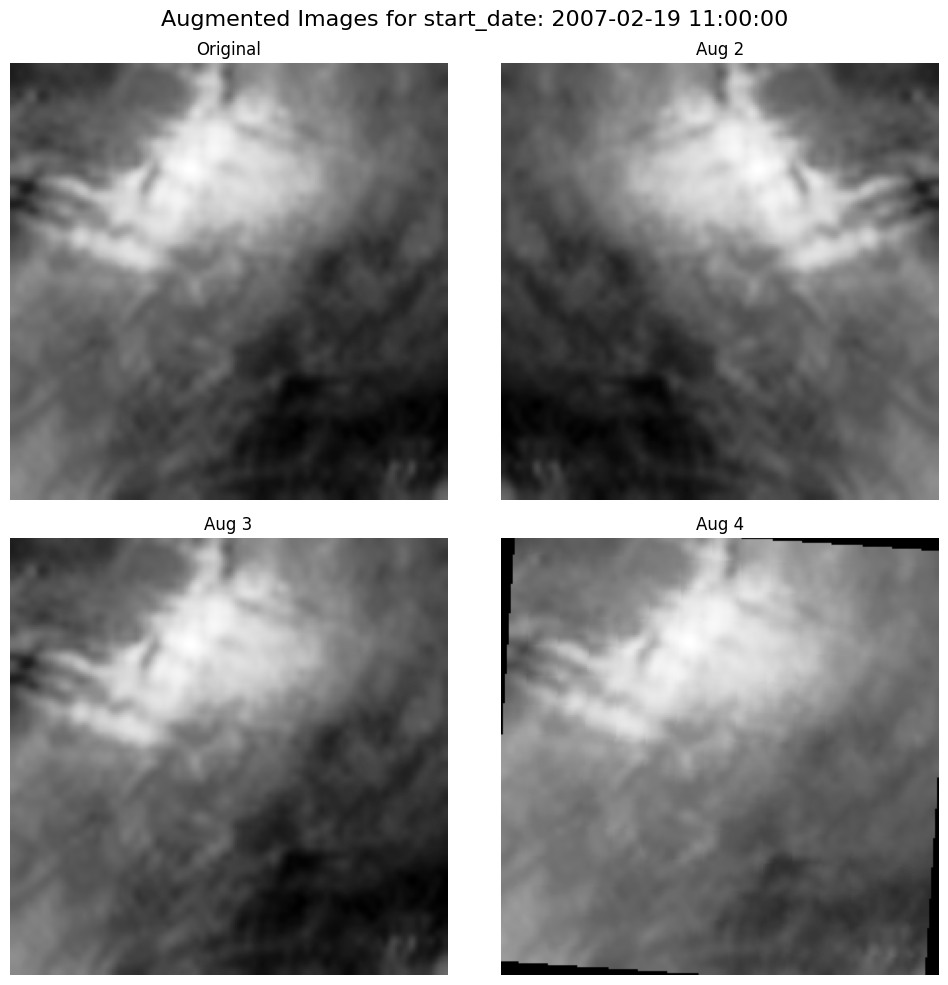

In [ ]:


def plot_subplots(filtered_data, title="Augmented Images", figsize=(10, 10), idx_channel = None):
    """
    Plot a grid of subplots for a given list of image data.

    Parameters:
    - filtered_data: List of tuples (date, image_data).
    - title: Title for the entire plot.
    - figsize: Tuple specifying figure size.
    """
    num_images = len(filtered_data)
    if num_images == 0:
        print("No images to plot.")
        return
    
    # Calculate grid size
    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easy iteration

    for idx, (start_date, image_data) in enumerate(filtered_data):
        ax = axes[idx]
        if idx_channel is not None:
            image_data = image_data[idx_channel]
            ax.imshow(image_data, cmap = cmap)  
        else:
            ax.imshow(np.transpose(image_data, (1, 2, 0)))

        ax.axis("off")  
        if idx == 0:
            ax.set_title(f"Original")
        else:
            ax.set_title(f"Aug {idx + 1}")

    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis("off")
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_subplots(filtered_resized_data, title=f"Augmented Images for start_date: {desired_date}", figsize=(10, 10), idx_channel=1)


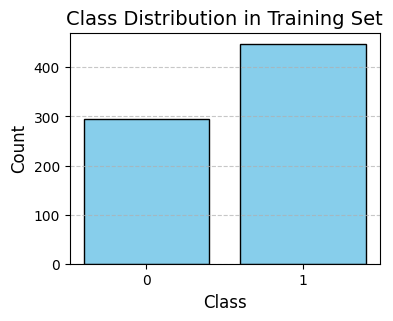

dataset Distribution: Counter({1: 448, 0: 294})


In [10]:
from collections import Counter

def plot_class_distribution(labels, dataset_name="Dataset"):
    """
    Plots the class distribution of the labels.
    :param labels: List or array-like containing class labels.
    :param dataset_name: Name of the dataset (e.g., "Training" or "Validation").
    """
    label_counts = Counter(labels)
    classes = list(label_counts.keys())
    counts = list(label_counts.values())
    
    # Plot
    plt.figure(figsize=(4, 3))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.title(f"Class Distribution in {dataset_name}", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(classes, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

_train_dataloader_one_batch = DataLoader(dataset, batch_size=1, shuffle=False)
all_train_labels = []

for _, label_tensor in _train_dataloader_one_batch:
    all_train_labels.append(label_tensor.item())

plot_class_distribution(all_train_labels, dataset_name="Training Set")

print("dataset Distribution:", Counter(all_train_labels))


In [12]:
from sklearn.model_selection import TimeSeriesSplit
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
    
n_splits = 5  
tscv = TimeSeriesSplit(n_splits = n_splits)
fold_metrics = []

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

patience = 5  # Number of epochs to wait before stopping if no improvement
counter = 0
for fold, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
    print(f"Fold {fold + 1}/{n_splits}")
    
    print("\tTRAIN indices:", train_idx)
    print("\VALIDATION indices:", val_idx)

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
        
    model.to(DEVICE)  

    criterion = FocalLoss(alpha=0.01, gamma=10, num_classes=2)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf') 
    
    for epoch in range(EPOCHS):
        # Training
        train_loss_epoch = 0

        train_loss = 0
        correct = 0
        total = 0
        
        model.train()
        for images, labels in train_loader:
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            train_loss_epoch += loss.item()

        train_losses.append(train_loss_epoch / len(train_loader))
        
        train_accuracies.append(100 * correct / total)
        
        # Validation
        model.eval()
        val_loss_epoch = 0

        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():

            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                val_loss_epoch += criterion(outputs, labels).item()
                
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(val_loss_epoch / len(val_loader))
        val_accuracies.append(100 * correct / total)
        
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

        # Early Stopping Logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset patience counter

            torch.save({
                'fold': fold + 1,
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            }, f'custom_cnn_best_model_fold_{fold + 1}.pth')

        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break  # Stop training if patience is exceeded


    plt.figure(figsize=(12, 5))   
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(val_accuracies, 'b-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Fold {fold + 1} - Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, 'r-', label='Training Loss')
    plt.plot(val_losses, 'b-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} - Training vs Validation Loss')
    plt.legend()
    plt.grid(True) 
    
    plt.tight_layout()
    plt.savefig(f'training_curves_fold_{fold + 1}.png')
    plt.close()

    fold_metrics.append((val_loss, val_accuracy))

avg_val_loss = np.mean([metrics[0] for metrics in fold_metrics])
avg_val_accuracy = np.mean([metrics[1] for metrics in fold_metrics])

print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Fold 1/5
	TRAIN indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
\VALIDATION indices: [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234

Evaluating Test Set with Best Model of Fold 1


/tmp/ipykernel_12383/3948474283.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"custom_cnn_best_model_fold_{fold + 1}.pth")


Fold 1 - Test Loss: 0.1624, Test Accuracy: 12.09%
Evaluating Test Set with Best Model of Fold 2
Fold 2 - Test Loss: 0.1624, Test Accuracy: 12.09%
Evaluating Test Set with Best Model of Fold 3
Fold 3 - Test Loss: 0.1624, Test Accuracy: 12.09%
Evaluating Test Set with Best Model of Fold 4
Fold 4 - Test Loss: 0.1624, Test Accuracy: 12.09%
Evaluating Test Set with Best Model of Fold 5
Fold 5 - Test Loss: 0.1624, Test Accuracy: 12.09%

Overall Test Loss (Average across folds): 0.1624
Overall Test Accuracy (Average across folds): 12.09%

Overall Classification Report:
                precision    recall  f1-score   support

Non Cloud Hole       0.00      0.00      0.00       800
    Cloud Hole       0.12      1.00      0.22       110

      accuracy                           0.12       910
     macro avg       0.06      0.50      0.11       910
  weighted avg       0.01      0.12      0.03       910



/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

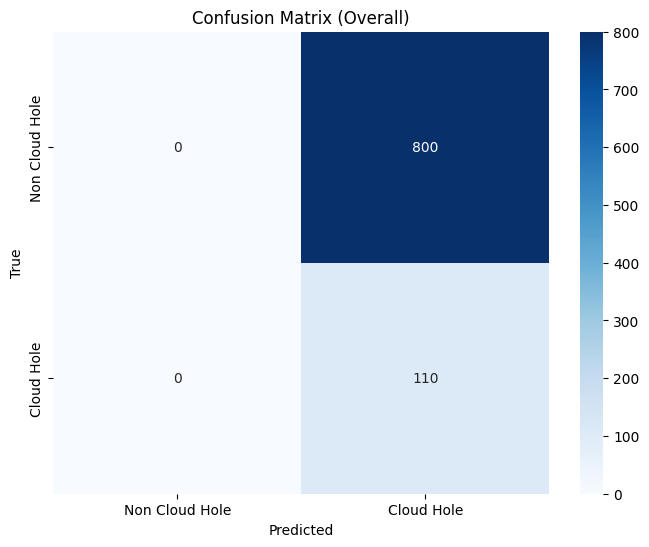

Final model trained and saved as final_model.pth


In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

fold_test_metrics = []  # To store metrics for each fold
all_test_labels = []
all_test_predictions = []

# Loop through all folds
for fold in range(n_splits):
    print(f"Evaluating Test Set with Best Model of Fold {fold + 1}")
    
    # Load the best model for this fold
    checkpoint = torch.load(f"custom_cnn_best_model_fold_{fold + 1}.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(DEVICE)

    # Initialize variables for fold-specific metrics
    test_loss = 0
    correct = 0
    total = 0
    fold_labels = []
    fold_predictions = []

    # Evaluate the model
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            # Get predicted classes
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store fold predictions and labels
            fold_labels.extend(labels.cpu().numpy())
            fold_predictions.extend(predicted.cpu().numpy())

    # Compute fold-specific metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Save metrics for this fold
    fold_test_metrics.append((test_loss, test_accuracy))
    all_test_labels.extend(fold_labels)
    all_test_predictions.extend(fold_predictions)

# Compute overall metrics
avg_test_loss = np.mean([metrics[0] for metrics in fold_test_metrics])
avg_test_accuracy = np.mean([metrics[1] for metrics in fold_test_metrics])

print(f"\nOverall Test Loss (Average across folds): {avg_test_loss:.4f}")
print(f"Overall Test Accuracy (Average across folds): {avg_test_accuracy:.2f}%")

# Classification Report and Confusion Matrix
print("\nOverall Classification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=["Non Cloud Hole", "Cloud Hole"]))

conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Cloud Hole", "Cloud Hole"], yticklabels=["Non Cloud Hole", "Cloud Hole"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Overall)")
plt.show()


torch.save(model.state_dict(), "custom_cnn_final_model.pth")
print("Final model trained and saved as final_model.pth")

/tmp/ipykernel_12383/2409840098.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("custom_cnn_final_model.pth"))



Final Model Test Loss: 0.1624
Final Model Test Accuracy: 12.09%

Final Model Classification Report:
                precision    recall  f1-score   support

Non Cloud Hole       0.00      0.00      0.00       160
    Cloud Hole       0.12      1.00      0.22        22

      accuracy                           0.12       182
     macro avg       0.06      0.50      0.11       182
  weighted avg       0.01      0.12      0.03       182



/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

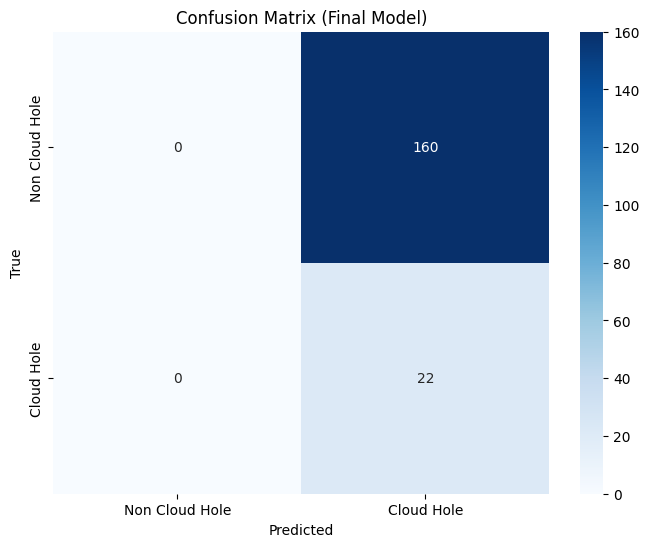

In [15]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.load_state_dict(torch.load("custom_cnn_final_model.pth"))
model.to(DEVICE)
model.eval()

# Initialize test metrics
test_loss = 0
correct = 0
total = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        test_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

# Compute final test accuracy
final_test_loss = test_loss / len(test_loader)
final_test_accuracy = 100 * correct / total

print(f"\nFinal Model Test Loss: {final_test_loss:.4f}")
print(f"Final Model Test Accuracy: {final_test_accuracy:.2f}%")

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nFinal Model Classification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=["Non Cloud Hole", "Cloud Hole"]))

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Cloud Hole", "Cloud Hole"], yticklabels=["Non Cloud Hole", "Cloud Hole"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Final Model)")
plt.show()